<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-das-bibliotecas" data-toc-modified-id="Download-das-bibliotecas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download das bibliotecas</a></span></li><li><span><a href="#Construção-do-Modelo" data-toc-modified-id="Construção-do-Modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construção do Modelo</a></span></li><li><span><a href="#Otimização-dos-Parâmetros" data-toc-modified-id="Otimização-dos-Parâmetros-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Otimização dos Parâmetros</a></span></li><li><span><a href="#Quantificação-de-Incertezas" data-toc-modified-id="Quantificação-de-Incertezas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quantificação de Incertezas</a></span></li><li><span><a href="#7-parameters" data-toc-modified-id="7-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>7 parameters</a></span></li><li><span><a href="#23-parameters" data-toc-modified-id="23-parameters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>23 parameters</a></span></li></ul></div>

## Download das bibliotecas

In [1]:
using Pkg
Pkg.activate("..")
Pkg.status()

Activating environment at `~/Documents/modelo-covid19/Project.toml`
    Status `~/Documents/modelo-covid19/Project.toml`
  [864edb3b] DataStructures v0.17.15
  [aae7a2af] DiffEqFlux v1.9.0
  [1130ab10] DiffEqParamEstim v1.14.0
  [41bf760c] DiffEqSensitivity v6.13.0
  [ef61062a] DiffEqUncertainty v1.4.1
  [0c46a032] DifferentialEquations v6.13.0
  [31c24e10] Distributions v0.21.12
  [587475ba] Flux v0.10.4
  [1b10255b] GlobalSensitivityAnalysis v0.0.10
  [429524aa] Optim v0.20.6
  [1dea7af3] OrdinaryDiffEq v5.35.5
  [65888b18] ParameterizedFunctions v5.3.0
  [438e738f] PyCall v1.91.4
  [d330b81b] PyPlot v2.9.0
  [8a4e6c94] QuasiMonteCarlo v0.2.0
  [e88e6eb3] Zygote v0.4.19


In [2]:
include("../src/dados.jl");

In [3]:
include("../src/models.jl");

┌ Warning: Replacing module `ForwardDiff`
└ @ Base loading.jl:942


In [4]:
include("../src/graphs.jl");

In [5]:
include("../src/parametrization.jl");

In [6]:
include("../src/optimization.jl");

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1273
┌ Warning: Module ForwardDiff with build ID 4612453959207 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1011
┌ Warning: Module ForwardDiff with build ID 4612453959207 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1011
┌ Info: Skipping precompilation since __precompile__(false). Importing DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0].
└ @ Base loading.jl:1028
┌ Info: Precompiling Tracker [9f7883ad-71c0-57eb-9f7f-b5c9e6d3789c]
└ @ Base loading.jl:1273
┌ Warning: Module ForwardDiff with build ID 4612453959207 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support

## Construção do Modelo

In [7]:
ts = 0.0:1.0:float(n_pts)
sol = model(params_rio_base, CI_Rio, ts);

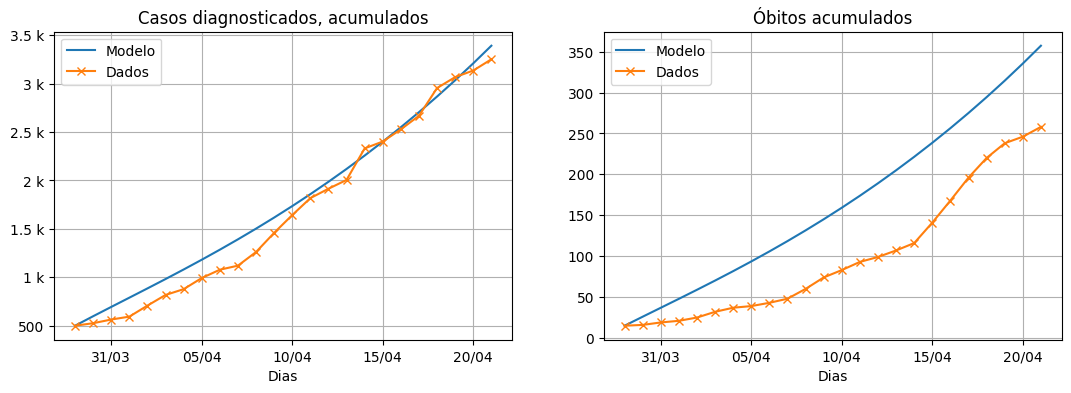

In [8]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_serie = "C0", cor_dados = "C1x-")
end

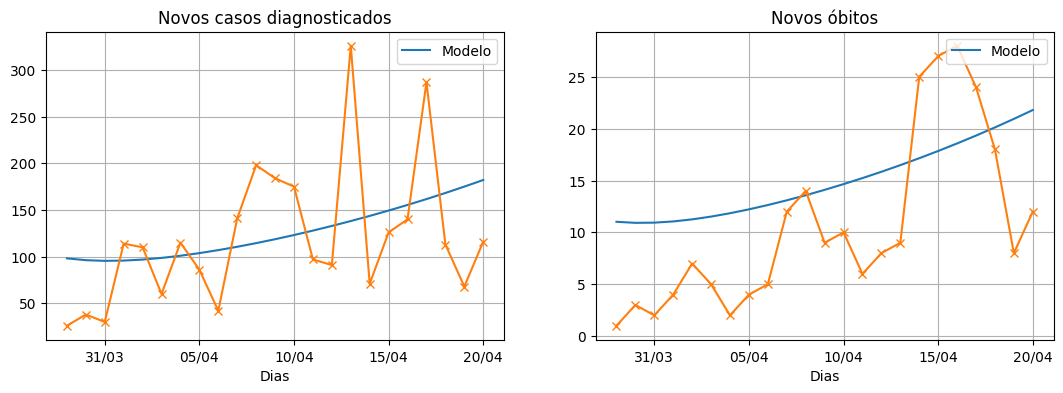

In [9]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax, cor_serie = "C0", cor_dados = "C1x-")
end

## Otimização dos Parâmetros

In [10]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 160.25940011462774
          Sintomática   = 1175.2356008406034
    
Taxa de contágio    = 2.1268425120951884
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.88
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [11]:
loss_obj(p_start)

339838.65687845246

In [12]:
res = DiffEqFlux.sciml_train(loss_adjoint, p_start, Fminbox(LBFGS()),
    lower_bounds=[0.0, 0.01, 0.4, 0.80, 0, 0.2, 2], upper_bounds=[1e-6, 0.2, 0.7, 0.90, 0.4, 0.6, 50])
    #cb = cb)

 * Status: success

 * Candidate solution
    Minimizer: [8.98e-08, 2.00e-01, 6.30e-01,  ...]
    Minimum:   3.306136e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.00e-07, 1.00e-01, 6.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.19e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    6
    f(x) calls:    3408
    ∇f(x) calls:   3408


In [13]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 160.25940011462774
          Sintomática   = 1175.2356008406034
    
Taxa de contágio    = 2.1268425120951884
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.88
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [14]:
pp_p_ci(res.minimizer)

População em quarentena = 4.229943300503046e6 = 62.95586199864839 %
          Exposta       = 4011.169313013568
          Assintom      = 140.22292279681847
          Sintomática   = 1262.00630510633
    
Taxa de contágio    = 1.8770063728554425
Fator cont assintom = 0.19999999999948279
Em quarentena       = 62.95586199864839 % 
Prop sintomática    = 0.899999999995362
Taxa testagem A     = 0.01795460341181788 ~ 55.696022744885084 dias
Taxa testagem I     = 0.02992434936052564 ~ 33.41760209894951 dias


In [15]:
Ts = 0.0:1.0:23
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);

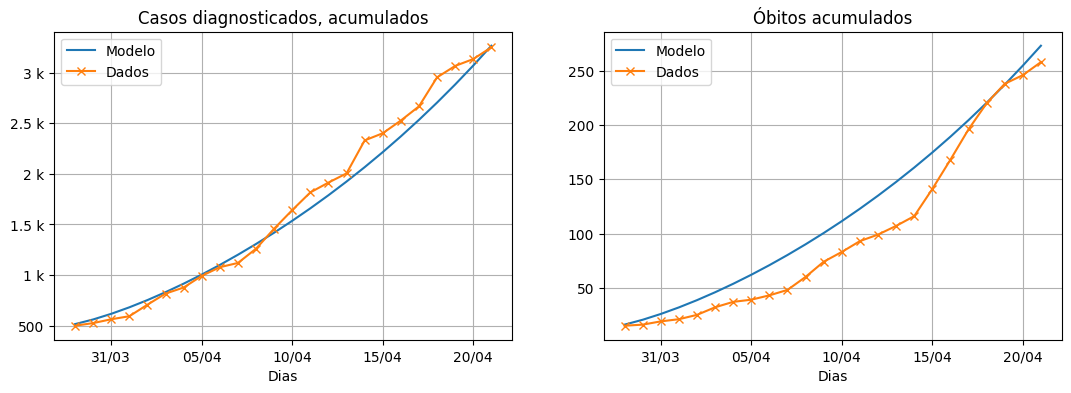

In [16]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,1:24],sol[10,1:24]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_serie = "C0", cor_dados = "C1x-")
end

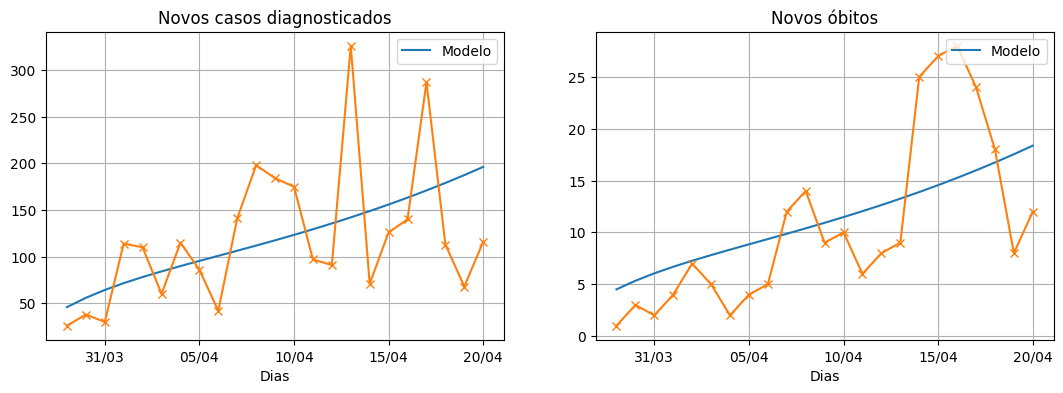

In [17]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,1:24],sol[10,1:24]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax, cor_serie = "C0", cor_dados = "C1x-")
end

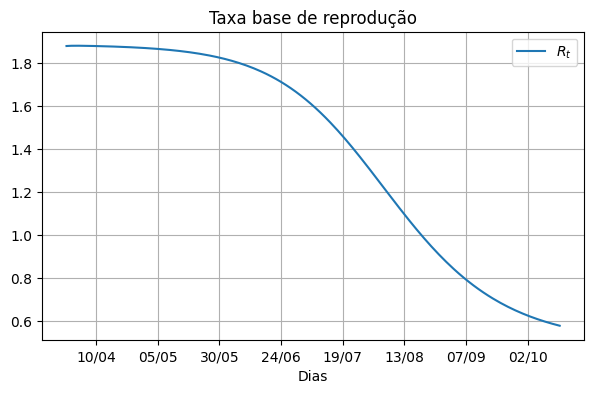

In [18]:
Ts = 0.0:1.0:200
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
serie = Rt(sol,p_opt)
ax.set_title("Taxa base de reprodução")
graph_py.plot_accum(serie, Rio_acc_d,real_data = false, label = L"R_t", ax = ax,blur = 1.0, eng_fmt = false)

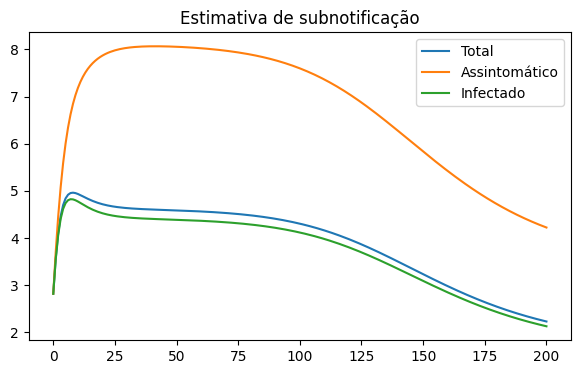

In [19]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
series_subnot = [(sol[4,:].+sol[5,:])./(sol[6,:].+sol[7,:]),(sol[4,:])./(sol[6,:]),(sol[5,:])./(sol[7,:])]
m_labels = ["Total", "Assintomático", "Infectado"]
ax.set_title("Estimativa de subnotificação")
for (serie,label) in zip(series_subnot,m_labels)
    ax.plot(serie, label = label)
end
ax.legend();

## Quantificação de Incertezas

In [20]:
ans_min = res.minimizer

7-element Array{Float64,1}:
 8.980381918390615e-8
 0.19999999999948279 
 0.6295586199864839  
 0.899999999995362   
 0.02992434936052564 
 0.5999997926605712  
 8.0545568534409     

In [21]:
lower_bounds=[0.0, 0.01, 0.4, 0.80, 0, 0.2, 2], upper_bounds=[1e-6, 0.2, 0.7, 0.90, 0.4, 0.6, 50]

ErrorException: syntax: invalid assignment location "[0, 0,01, 0,4, 0,8, 0, 0,2, 2]"

In [22]:
p_start = vcat(CI_Rio,params_rio_base)

23-element Array{Float64,1}:
    2.6800912e6        
    4.0313418e6        
 3486.0                
 3984.0                
 3984.0                
   49.800000000000004  
  448.2                
    0.0                
  498.0                
   15.0                
    1.0e-7             
    0.1                
    0.2222222222222222 
    0.18181818181818182
    0.14285714285714285
    0.55               
    0.005              
    0.0996             
    0.02               
    0.0766             
    0.0026             
    0.0843             
    0.0017             

In [23]:
full_data = SobolData(
    params = OrderedDict(
        :S => Uniform(0, 6e6),
        :Q => Uniform(0, 6e6),
        :E => Uniform(0, 1e4),
        :A => Uniform(0, 1e4),
        :I => Uniform(0, 1e4),
        :DA => Uniform(0, 1e4),
        :DI => Uniform(0, 1e4),
        :R => Uniform(0, 1e4),
        :C => Uniform(0, 1e4),
        :M => Uniform(0, 1e4),
        
        :β => Uniform(0.0, 1e-6),
        :θ => Uniform(0.0, 1.00),
        :p => Uniform(0.0, 1.00),
        :λ => Uniform(0.0, 1.00),
        :σ => Uniform(0.0, 1.00),
        :ρ => Uniform(0.07, 1.00),
        :ϵ_a => Uniform(0.01 , 1.0),
        :γ_a => Uniform(0.01 , 1.0),
        :ϵ_i => Uniform(0.01 , 1.0),
        :γ_i => Uniform(0.01 , 1.0),
        :d_i => Uniform(0.0001 , 0.2),
        :γ_d => Uniform(0.01 , 1.0),
        :d_d => Uniform(0.0001 , 0.2)),
    N = 2000
);

In [57]:
new_data = SobolData(
    params = OrderedDict(:x1 => Uniform(0.0, 1e-6),
        :x2 => Uniform(0.00, 0.90),
        :x3 => Uniform(0.00, 0.90),
        :x4 => Uniform(0.00, 0.90),
        :x5 => Uniform(0.01 , 0.90),
        :x6 => Uniform(0.01 , 0.60),
        :x7 => Uniform(2, 50)),
    N = 2000
);

In [25]:
data = SobolData(
    params = OrderedDict(:x1 => Uniform(ans_min[1]*0.9, ans_min[1]*1.1),
        :x2 => Uniform(ans_min[2]*0.999, ans_min[2]*1.0),
        :x3 => Uniform(ans_min[3] - 0.20, ans_min[3] + 0.20),
        :x4 => Uniform(ans_min[4]*0.999, ans_min[4]*1.0),
        :x5 => Uniform(1/(1/res.minimizer[5] + 10) , 1/(1/res.minimizer[5] - 10)),
        :x6 => Uniform(ans_min[6]*0.999, ans_min[6]*1.00),
        :x7 => Uniform(ans_min[7]*0.8, ans_min[7]*1.2)),
    N = 100
);

In [58]:
Random.seed!(1)
samples = GlobalSensitivityAnalysis.sample(data)
new_samples = GlobalSensitivityAnalysis.sample(new_data)
full_samples = GlobalSensitivityAnalysis.sample(full_data)

96000×23 Array{Float64,2}:
 1.31836e6  5.80078e5  5185.55  6767.58   …  0.10454    0.554307  0.190044 
 3.24023e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  3.49805e6  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  9072.27  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55   400.391     0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58   …  0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58   …  0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554307  0.190044 
 1.31836e6  5.80078e5  5185.55  6767.58      0.10454    0.554

In [59]:
function loss_obj(p_ci)
    # Initial condition and Parameters
    full_ci, p = build_p_ci(p_ci)
    
    prob = ODEProblem(g, full_ci, (0.0,float(n_pts+1)), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:float(n_pts+1)))
    if size(sol)[2] < 25
        return 1e7
    else
        return loss(sol)
    end
end

loss_obj (generic function with 1 method)

In [77]:
function loss_obj_max_dd(p_start)
    if length(p_start) == 7
        full_ci, p = build_p_ci(p_start)
    else
        full_ci, p = p_start[1:10], p_start[11:23]
    end
    
    prob = ODEProblem(g, full_ci, (0.0,200), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:200.0))
    if size(sol)[2] < 200
        return 1e7
    else
        arr = sol[9,:][2:200] .- sol[9,:][1:199]
        max_arr = maximum(arr)
        return findfirst(x-> x == max_arr, arr)
    end
end

loss_obj_max_dd (generic function with 1 method)

In [78]:
function loss_obj_max_do(p_start)
    if length(p_start) == 7
        full_ci, p = build_p_ci(p_start)
    else
        full_ci, p = p_start[1:10], p_start[11:23]
    end
    
    prob = ODEProblem(g, full_ci, (0.0,200), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:200.0))
    if size(sol)[2] < 200
        return 1e7
    else
        arr = sol[10,:][2:200] .- sol[10,:][1:199]
        max_arr = maximum(arr)
        return findfirst(x-> x == max_arr, arr)
    end
end

loss_obj_max_do (generic function with 1 method)

In [79]:
function loss_obj_max_d(p_start)
    if length(p_start) == 7
        full_ci, p = build_p_ci(p_start)
    else
        full_ci, p = p_start[1:10], p_start[11:23]
    end
    
    prob = ODEProblem(g, full_ci, (0.0,200), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:200.0))
    if size(sol)[2] < 200
        return 1e7
    else
        return sol[9,:][end]
    end
end

loss_obj_max_d (generic function with 1 method)

In [80]:
function loss_obj_max_o(p_start)
    if length(p_start) == 7
        full_ci, p = build_p_ci(p_start)
    else
        full_ci, p = p_start[1:10], p_start[11:23]
    end
    
    prob = ODEProblem(g, full_ci, (0.0,200), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:200.0))
    if size(sol)[2] < 200
        return 1e7
    else
        return sol[10,:][end]
    end
end

loss_obj_max_o (generic function with 1 method)

In [81]:
function loss_obj_rt_less_1(p_start)
    if length(p_start) == 7
        full_ci, p = build_p_ci(p_start)
    else
        full_ci, p = p_start[1:10], p_start[11:23]
    end
    
    prob = ODEProblem(g, full_ci, (0.0,200), p)
    # build_loss_objective(prob, Tsit5(), loss, maxiters=10000, verbose=false)
    sol = Array(concrete_solve(prob,Tsit5(), full_ci, p, saveat=0.0:1.0:200.0))
    if size(sol)[2] < 200
        return 1e7
    else
        Rts = Rt(sol,p)
        first = findfirst(x-> x <= 1, Rts)
        if first == nothing
            return 1e7
        else
            return first
        end
    end
end

loss_obj_rt_less_1 (generic function with 1 method)

In [33]:
loss_obj_max_d(p_start),loss_obj_max_o(p_start)

(550945.7041875214, 68362.58509230442)

In [34]:
loss_obj(p_start)

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/rafael/.julia/packages/DiffEqBase/XoVg5/src/integrator_interface.jl:343


1.0e7

## 7 parameters

In [61]:
all_loss_new = [loss_obj(p) for p in eachrow(new_samples)];

In [82]:
all_loss_7_max_dd = [loss_obj_max_dd(p) for p in eachrow(new_samples)];

In [83]:
all_loss_7_max_d = [loss_obj_max_d(p) for p in eachrow(new_samples)];

In [84]:
all_loss_7_max_o = [loss_obj_max_o(p) for p in eachrow(new_samples)];

In [85]:
all_loss_7_max_do = [loss_obj_max_do(p) for p in eachrow(new_samples)];

In [86]:
all_loss_7_rt_less_1 = [loss_obj_rt_less_1(p) for p in eachrow(new_samples)];

In [66]:
answer_loss = analyze(new_data, all_loss_new);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:28


In [87]:
answer_7_max_dd = analyze(new_data, all_loss_7_max_dd);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:28


In [88]:
answer_7_max_d = analyze(new_data, all_loss_7_max_d);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:27


In [89]:
answer_7_max_o = analyze(new_data, all_loss_7_max_o);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:27


In [90]:
answer_7_max_do = analyze(new_data, all_loss_7_max_do);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:28


In [91]:
answer_7_rt_less_1 = analyze(new_data, all_loss_7_rt_less_1);

Calculating indices for 7 parameters ...100%|███████████| Time: 0:00:28


In [48]:
using Printf

In [109]:
function print_analysis_7(analysis)
    labels = ["Taxa de contágio", "Fator cont assintom", "Quarentena", "Prop sintomática", "Taxa testagem I",
        "Taxa testagem A", "Subnotificação"]
    for i = 1:length(labels)
        sigma = analysis[:totalorder_conf][i]
        v = analysis[:totalorder][i]
        lb = v - sigma
        ub = v + sigma
        @printf  "%20s = % .5e [% .5e, % .5e] \n" labels[i] analysis[:totalorder][i] lb ub
    end
end

print_analysis_7 (generic function with 1 method)

In [110]:
println("Sobol indices for loss function")
print_analysis_7(answer_loss)

Sobol indices for loss function
    Taxa de contágio =  6.30406e-01 [ 5.28217e-01,  7.32596e-01] 
 Fator cont assintom =  1.72756e-01 [ 1.33939e-01,  2.11573e-01] 
          Quarentena =  5.65569e-01 [ 4.72151e-01,  6.58986e-01] 
    Prop sintomática =  2.23364e-01 [ 1.74569e-01,  2.72159e-01] 
     Taxa testagem I =  1.27338e-01 [ 9.87556e-02,  1.55921e-01] 
     Taxa testagem A =  2.87548e-02 [ 1.75060e-02,  4.00036e-02] 
      Subnotificação =  4.88250e-02 [ 3.70808e-02,  6.05693e-02] 


In [111]:
println("Sobol Indices for which day has maximum daily diagnosys")
print_analysis_7(answer_7_max_dd)

Sobol Indices for which day has maximum daily diagnosys
    Taxa de contágio =  8.86297e-01 [ 8.06263e-01,  9.66330e-01] 
 Fator cont assintom =  5.63381e-01 [ 4.91230e-01,  6.35533e-01] 
          Quarentena =  7.48076e-01 [ 6.74165e-01,  8.21987e-01] 
    Prop sintomática =  3.13055e-01 [ 2.56705e-01,  3.69406e-01] 
     Taxa testagem I =  5.93176e-01 [ 5.18393e-01,  6.67960e-01] 
     Taxa testagem A =  2.92780e-01 [ 2.33138e-01,  3.52422e-01] 
      Subnotificação =  3.96603e-02 [ 2.92774e-02,  5.00433e-02] 


In [112]:
println("Sobol Indices for accumulated diagnosys")
print_analysis_7(answer_7_max_d)

Sobol Indices for accumulated diagnosys
    Taxa de contágio =  5.67169e-01 [ 5.22072e-01,  6.12265e-01] 
 Fator cont assintom =  1.39920e-01 [ 1.20402e-01,  1.59437e-01] 
          Quarentena =  3.57348e-01 [ 3.21961e-01,  3.92734e-01] 
    Prop sintomática =  1.28682e-01 [ 1.13261e-01,  1.44103e-01] 
     Taxa testagem I =  2.08553e-01 [ 1.90564e-01,  2.26542e-01] 
     Taxa testagem A =  6.70817e-02 [ 5.90497e-02,  7.51138e-02] 
      Subnotificação =  7.75857e-04 [ 5.32603e-04,  1.01911e-03] 


In [113]:
println("Sobol Indices for which day has maximum daily deaths")
print_analysis_7(answer_7_max_do)

Sobol Indices for which day has maximum daily deaths
    Taxa de contágio =  8.79266e-01 [ 8.00406e-01,  9.58127e-01] 
 Fator cont assintom =  5.33114e-01 [ 4.65645e-01,  6.00582e-01] 
          Quarentena =  7.51024e-01 [ 6.77965e-01,  8.24082e-01] 
    Prop sintomática =  3.10311e-01 [ 2.56182e-01,  3.64440e-01] 
     Taxa testagem I =  5.73609e-01 [ 5.01482e-01,  6.45735e-01] 
     Taxa testagem A =  2.71792e-01 [ 2.17005e-01,  3.26579e-01] 
      Subnotificação =  4.43728e-02 [ 2.91612e-02,  5.95844e-02] 


In [114]:
println("Sobol Indices for accumulated deaths")
print_analysis_7(answer_7_max_o)

Sobol Indices for accumulated deaths
    Taxa de contágio =  3.40809e-01 [ 3.05056e-01,  3.76562e-01] 
 Fator cont assintom =  3.25083e-02 [ 2.74671e-02,  3.75494e-02] 
          Quarentena =  1.93547e-01 [ 1.69747e-01,  2.17347e-01] 
    Prop sintomática =  5.64344e-01 [ 5.24280e-01,  6.04408e-01] 
     Taxa testagem I =  1.68733e-01 [ 1.44198e-01,  1.93269e-01] 
     Taxa testagem A =  1.09024e-02 [ 8.32876e-03,  1.34761e-02] 
      Subnotificação =  4.99039e-04 [ 3.28612e-04,  6.69467e-04] 


In [115]:
println("Sobol Indices for which day R_t becomes less than 1 (epidemic end)")
print_analysis_7(answer_7_rt_less_1)

Sobol Indices for which day R_t becomes less than 1 (epidemic end)
    Taxa de contágio =  9.72809e-01 [ 7.65704e-01,  1.17991e+00] 
 Fator cont assintom =  8.39044e-01 [ 6.46162e-01,  1.03193e+00] 
          Quarentena =  7.53925e-01 [ 5.71346e-01,  9.36505e-01] 
    Prop sintomática =  6.08002e-01 [ 4.40726e-01,  7.75278e-01] 
     Taxa testagem I =  7.78246e-01 [ 5.90476e-01,  9.66017e-01] 
     Taxa testagem A =  5.71522e-01 [ 4.09096e-01,  7.33948e-01] 
      Subnotificação =  4.49914e-01 [ 3.07381e-01,  5.92447e-01] 


## 23 parameters

In [36]:
all_loss_max_dd = [loss_obj_max_dd(p) for p in eachrow(full_samples)];

In [37]:
all_loss_max_d = [loss_obj_max_d(p) for p in eachrow(full_samples)];

In [38]:
all_loss_max_o = [loss_obj_max_o(p) for p in eachrow(full_samples)];

In [39]:
all_loss_max_do = [loss_obj_max_do(p) for p in eachrow(full_samples)];

In [40]:
all_loss_rt_less_1 = [loss_obj_rt_less_1(p) for p in eachrow(full_samples)];

In [42]:
answer_max_dd = analyze(full_data, all_loss_max_dd)

Calculating indices for 23 parameters ...100%|██████████| Time: 0:04:41


Dict{Symbol,Array} with 6 entries:
  :firstorder       => [0.0148763, 0.00796613, -0.00521186, -0.0105343, 0.00266…
  :secondorder_conf => Union{Missing, Float64}[missing 0.0513118 … 0.0591166 0.…
  :totalorder_conf  => [0.077154, 0.119954, 0.00519946, 0.0452413, 0.0387134, 4…
  :totalorder       => [0.380267, 0.574377, 0.00813381, 0.0591145, 0.0463328, 9…
  :firstorder_conf  => [0.0406038, 0.0409659, 0.00463087, 0.0196267, 0.011787, …
  :secondorder      => Union{Missing, Float64}[missing 0.000375364 … 0.00383332…

In [43]:
answer_max_d = analyze(full_data, all_loss_max_d)

Calculating indices for 23 parameters ...100%|██████████| Time: 0:04:40


Dict{Symbol,Array} with 6 entries:
  :firstorder       => [0.109342, 0.0987982, 0.000187673, 3.31738e-5, -0.000695…
  :secondorder_conf => Union{Missing, Float64}[missing 0.0522415 … 0.0467424 0.…
  :totalorder_conf  => [0.0264343, 0.0266264, 0.00010103, 8.13015e-5, 0.0002254…
  :totalorder       => [0.228341, 0.227024, 9.93028e-5, 9.86299e-5, 0.00021267,…
  :firstorder_conf  => [0.0333919, 0.0302447, 0.000452064, 0.000481209, 0.00076…
  :secondorder      => Union{Missing, Float64}[missing -0.0115677 … -0.018331 -…

In [44]:
answer_max_do = analyze(full_data, all_loss_max_do)

Calculating indices for 23 parameters ...100%|██████████| Time: 0:04:41


Dict{Symbol,Array} with 6 entries:
  :firstorder       => [0.023452, 0.015491, -0.00114386, -0.0034687, 0.00601309…
  :secondorder_conf => Union{Missing, Float64}[missing 0.0583816 … 0.0500582 0.…
  :totalorder_conf  => [0.0698573, 0.117728, 0.0293232, 0.0044229, 0.0425285, 1…
  :totalorder       => [0.355158, 0.575194, 0.0297821, 0.00825621, 0.0709835, 1…
  :firstorder_conf  => [0.0400175, 0.0367559, 0.00638536, 0.0044616, 0.0195379,…
  :secondorder      => Union{Missing, Float64}[missing 0.00795785 … -0.0101955 …

In [45]:
answer_max_o = analyze(full_data, all_loss_max_o)

Calculating indices for 23 parameters ...100%|██████████| Time: 0:04:41


Dict{Symbol,Array} with 6 entries:
  :firstorder       => [0.0604137, 0.067017, -5.79858e-5, -1.13774e-5, -0.00031…
  :secondorder_conf => Union{Missing, Float64}[missing 0.0390378 … 0.0387421 0.…
  :totalorder_conf  => [0.0365426, 0.0269132, 8.55123e-5, 9.44315e-5, 0.0001936…
  :totalorder       => [0.178279, 0.155416, 7.46241e-5, 7.03041e-5, 0.000165357…
  :firstorder_conf  => [0.0250285, 0.0214279, 0.000304391, 0.00025492, 0.000536…
  :secondorder      => Union{Missing, Float64}[missing -0.0137158 … -0.00827805…

In [46]:
answer_rt_less_1 = analyze(full_data, all_loss_rt_less_1)

Calculating indices for 23 parameters ...100%|██████████| Time: 0:04:53


Dict{Symbol,Array} with 6 entries:
  :firstorder       => [-0.0010508, -0.00105136, 0.000525977, 6.00532e-8, 0.000…
  :secondorder_conf => Union{Missing, Float64}[missing 0.00678509 … 0.00678517 …
  :totalorder_conf  => [0.283598, 0.203912, 0.0589379, 3.20438e-12, 0.101571, 0…
  :totalorder       => [0.71193, 0.355964, 0.0296631, 4.95121e-12, 0.0889894, 0…
  :firstorder_conf  => [0.00503233, 0.0035954, 0.00104506, 1.55021e-7, 0.001784…
  :secondorder      => Union{Missing, Float64}[missing -0.00368229 … -0.0036826…

In [103]:
function print_analysis(analysis)
    labels = ["S","Q" ,"E" ,"A" ,"I" ,"DA" ,"DI","R" ,"C" ,"M","β" ,"θ","p" ,"λ" ,"σ" ,"ρ" ,"ϵ_a" 
    ,"γ_a" ,"ϵ_i" ,"γ_i" ,"d_i" ,"γ_d" ,"d_d"]
    for i = 1:length(labels)
        sigma = analysis[:totalorder_conf][i]
        v = analysis[:totalorder][i]
        lb = v - sigma
        ub = v + sigma
        @printf  "%3s = % .5e [% .5e, % .5e] \n" labels[i] analysis[:totalorder][i] lb ub
    end
end

print_analysis (generic function with 1 method)

In [104]:
println("Sobol Indices for which day has maximum daily diagnosys")
print_analysis(answer_max_dd)

Sobol Indices for which day has maximum daily diagnosys
  S =  3.80267e-01 [ 3.03113e-01,  4.57421e-01] 
  Q =  5.74377e-01 [ 4.54423e-01,  6.94331e-01] 
  E =  8.13381e-03 [ 2.93434e-03,  1.33333e-02] 
  A =  5.91145e-02 [ 1.38732e-02,  1.04356e-01] 
  I =  4.63328e-02 [ 7.61942e-03,  8.50461e-02] 
 DA =  9.41491e-06 [ 5.26221e-06,  1.35676e-05] 
 DI =  1.71486e-05 [ 1.10897e-05,  2.32075e-05] 
  R =  8.06992e-06 [ 3.54881e-06,  1.25910e-05] 
  C =  5.04370e-06 [ 2.50754e-06,  7.57986e-06] 
  M =  1.34499e-06 [ 5.58290e-08,  2.63414e-06] 
  β =  7.66506e-01 [ 6.43822e-01,  8.89190e-01] 
  θ =  2.86702e-01 [ 2.13500e-01,  3.59904e-01] 
  p =  4.71150e-01 [ 3.71168e-01,  5.71132e-01] 
  λ =  4.31796e-01 [ 3.39244e-01,  5.24349e-01] 
  σ =  5.29369e-01 [ 4.24792e-01,  6.33946e-01] 
  ρ =  3.32798e-01 [ 2.42260e-01,  4.23336e-01] 
ϵ_a =  2.40821e-01 [ 1.68552e-01,  3.13091e-01] 
γ_a =  1.78360e-01 [ 1.23228e-01,  2.33491e-01] 
ϵ_i =  3.42356e-01 [ 2.48872e-01,  4.35839e-01] 
γ_i =  3.8025

In [100]:
println("Sobol Indices for accumulated diagnosys")
print_analysis(answer_max_d)

Sobol Indices for accumulated diagnosys
  S =  2.28341e-01 
  Q =  2.27024e-01 
  E =  9.93028e-05 
  A =  9.86299e-05 
  I =  2.12670e-04 
 DA =  1.31297e-14 
 DI =  2.70386e-14 
  R =  2.17109e-14 
  C =  3.60892e-06 
  M =  4.29227e-16 
  β =  3.62139e-01 
  θ =  8.18541e-02 
  p =  1.18409e-01 
  λ =  1.67525e-01 
  σ =  2.22991e-02 
  ρ =  9.35241e-02 
ϵ_a =  4.40503e-02 
γ_a =  9.80344e-02 
ϵ_i =  6.38352e-02 
γ_i =  1.21001e-01 
d_i =  1.03860e-02 
γ_d =  1.63538e-13 
d_d =  8.14775e-15 


In [101]:
println("Sobol Indices for which day has maximum daily deaths")
print_analysis(answer_max_do)

Sobol Indices for which day has maximum daily deaths
  S =  3.55158e-01 
  Q =  5.75194e-01 
  E =  2.97821e-02 
  A =  8.25621e-03 
  I =  7.09835e-02 
 DA =  1.42134e-06 
 DI =  6.56379e-02 
  R =  1.77668e-06 
  C =  1.77668e-06 
  M =  7.10670e-07 
  β =  7.46799e-01 
  θ =  2.38280e-01 
  p =  4.16528e-01 
  λ =  3.90502e-01 
  σ =  4.78754e-01 
  ρ =  4.34934e-01 
ϵ_a =  1.47794e-01 
γ_a =  1.78671e-01 
ϵ_i =  3.70504e-01 
γ_i =  4.71517e-01 
d_i =  7.88105e-02 
γ_d =  1.17566e-02 
d_d =  5.25374e-02 


In [102]:
println("Sobol Indices for accumulated deaths")
print_analysis(answer_max_o)

Sobol Indices for accumulated deaths
  S =  1.78279e-01 
  Q =  1.55416e-01 
  E =  7.46241e-05 
  A =  7.03041e-05 
  I =  1.65357e-04 
 DA =  2.77316e-14 
 DI =  2.44467e-06 
  R =  1.09797e-14 
  C =  1.24229e-13 
  M =  2.98290e-05 
  β =  2.93127e-01 
  θ =  1.49744e-02 
  p =  6.66036e-02 
  λ =  1.38360e-01 
  σ =  1.38305e-02 
  ρ =  3.38927e-01 
ϵ_a =  6.37540e-03 
γ_a =  7.25090e-03 
ϵ_i =  1.18888e-01 
γ_i =  2.26439e-01 
d_i =  6.23990e-02 
γ_d =  1.20980e-01 
d_d =  4.82511e-02 


In [54]:
println("Sobol Indices for which day R_t becomes less than 1 (epidemic end)")
print_analysis(answer_rt_less_1)

Sobol Indices for which day R_t becomes less than 1 (epidemic end)
  S = -1.05080e-03 
  Q = -1.05136e-03 
  E =  5.25977e-04 
  A =  6.00532e-08 
  I =  5.26010e-04 
 DA =  0.00000e+00 
 DI =  0.00000e+00 
  R =  0.00000e+00 
  C =  0.00000e+00 
  M =  0.00000e+00 
  β =  5.28278e-04 
  θ = -5.25879e-04 
  p =  1.05243e-03 
  λ = -2.10347e-03 
  σ =  1.80087e-01 
  ρ = -1.57803e-03 
ϵ_a = -1.05241e-03 
γ_a =  1.47207e-07 
ϵ_i = -2.10386e-03 
γ_i =  1.05199e-03 
d_i =  1.05186e-03 
γ_d = -5.25980e-11 
d_d =  0.00000e+00 


In [65]:
answer[:firstorder]

7-element Array{Float64,1}:
  0.27547592869473847 
  0.015322553890740198
  0.19805393788014994 
  0.016912387235463695
 -0.007648738782126129
  0.001825169544821538
  0.019054660657820847

In [23]:
@time series = prob_adjust(model, (a,b) -> 1, res -> likelihood(res, σ=1e5), param_range_uq(samples), tol = 0.001);

 17.558942 seconds (14.90 M allocations: 2.640 GiB, 6.41% gc time)


In [38]:
idxs = Random.rand(1:length(series), 2000);
idxs = collect(1:1:length(series));

In [39]:
diagn_samples = (hcat([series[j][1]["res"][9,1:24] for j in idxs]...))
death_samples = (hcat([series[j][1]["res"][10,1:24] for j in idxs]...));

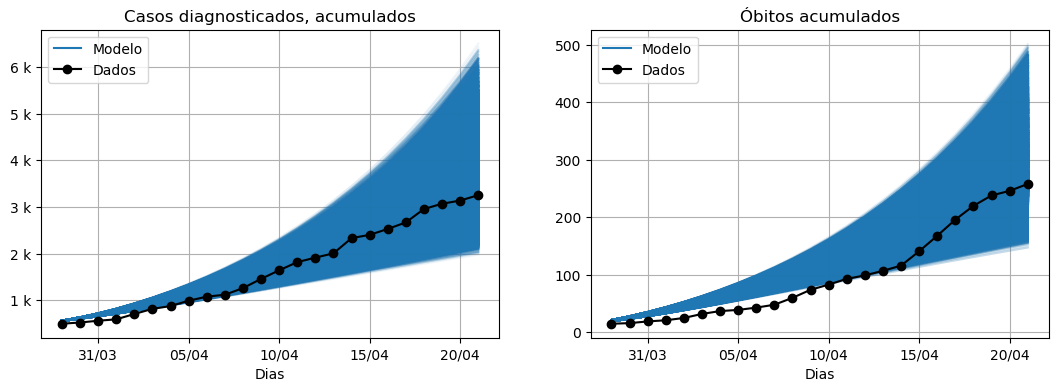

In [40]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo"),
                 mlines.Line2D([], [], color="k", marker = "o", label = "Dados")]
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_accum(model, data, real_data = true, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

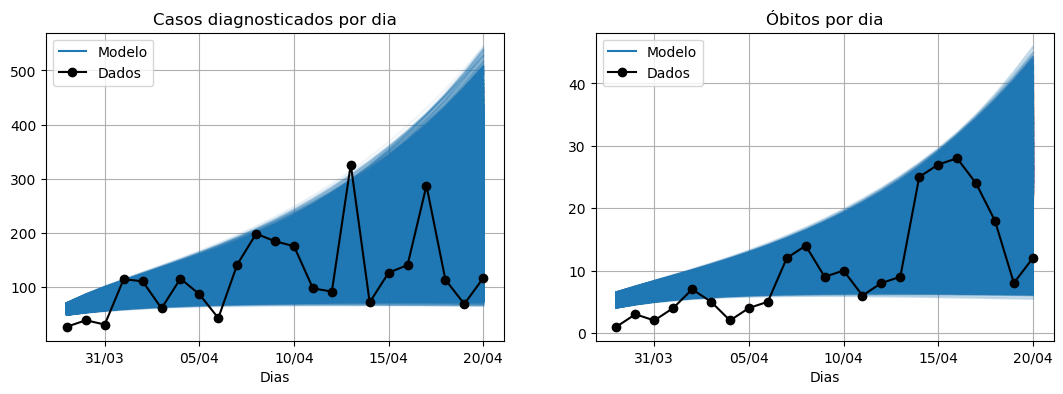

In [41]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados por dia")
axs[2].set_title("Óbitos por dia")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo"),
                 mlines.Line2D([], [], color="k", marker = "o", label = "Dados")]
axs[1].legend(custom_lines)
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_daily(model, data, real_data = true, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

In [42]:
diagn_samples = (hcat([series[j][1]["res"][9,1:end] for j in idxs]...))
death_samples = (hcat([series[j][1]["res"][10,1:end] for j in idxs]...));

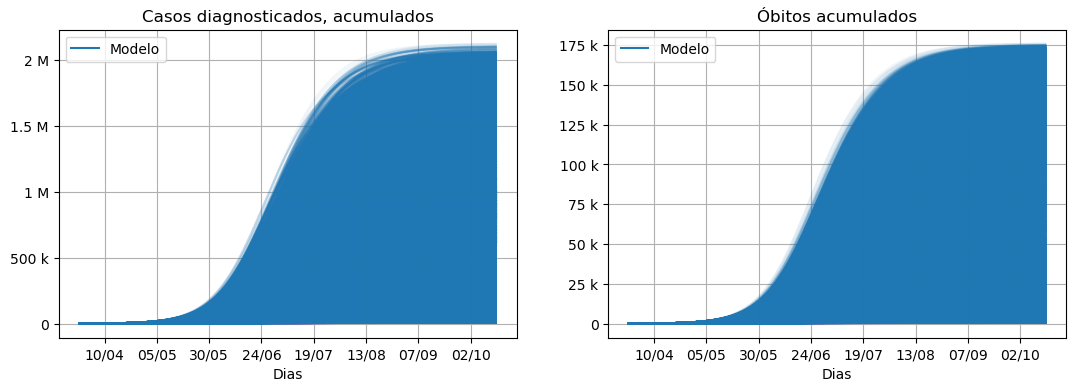

In [43]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo")]
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_accum(model, data, real_data = false, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

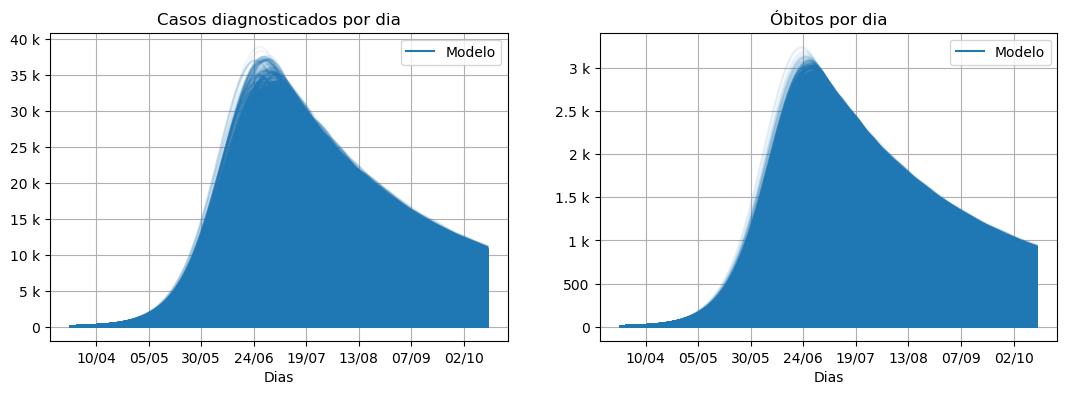

In [44]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
models = [diagn_samples,death_samples]
axs[1].set_title("Casos diagnosticados por dia")
axs[2].set_title("Óbitos por dia")
custom_lines = [ mlines.Line2D([], [], color="C0", label = "Modelo")]
axs[1].legend(custom_lines)
for (ax,data, model) in zip(axs, datas, models)
    graph_py.plot_daily(model, data, real_data = false, label = nothing, ax = ax, blur = 0.07, cor_serie = "C0", cor_dados = "ko-", legend = false)
    ax.legend(handles=custom_lines)
end

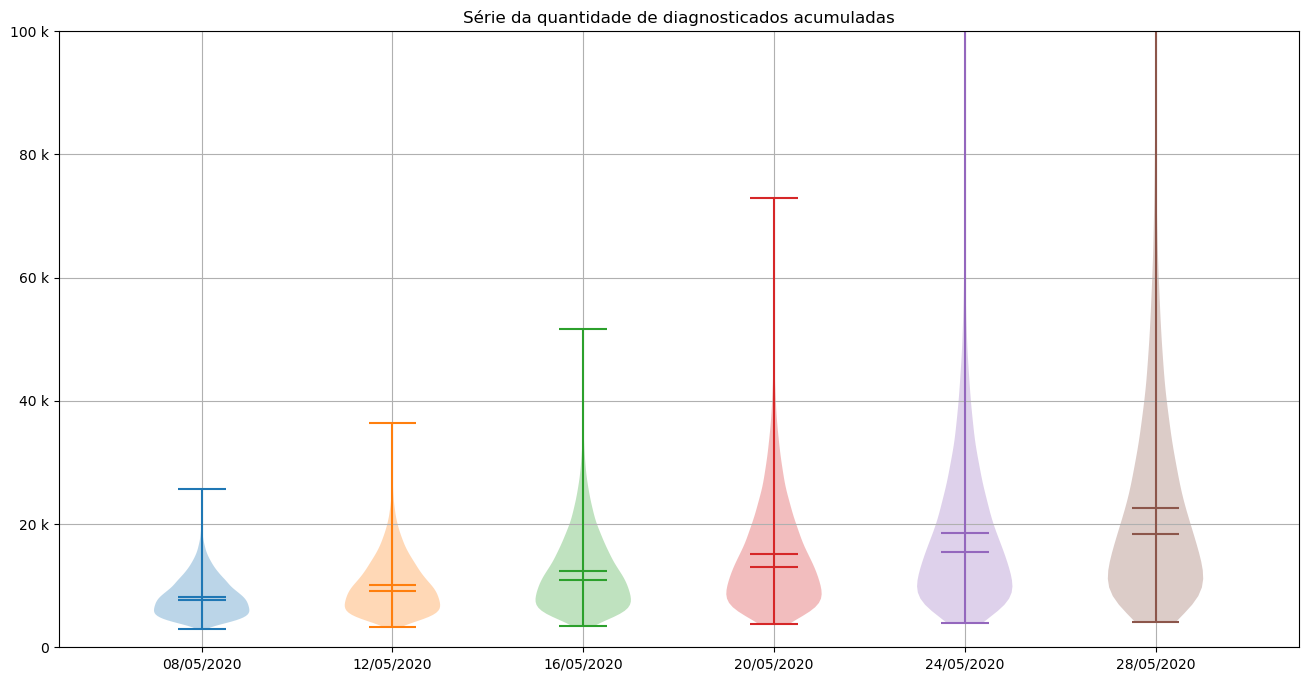

In [45]:
ts = 40:4:60
xs, ws = build_series(series, idxs, ts, index = 9);
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Série da quantidade de diagnosticados acumuladas")
ax.set_ylim(0,100000)
ax.grid()
graph_py.graph_series(xs,ws,ts,ax)

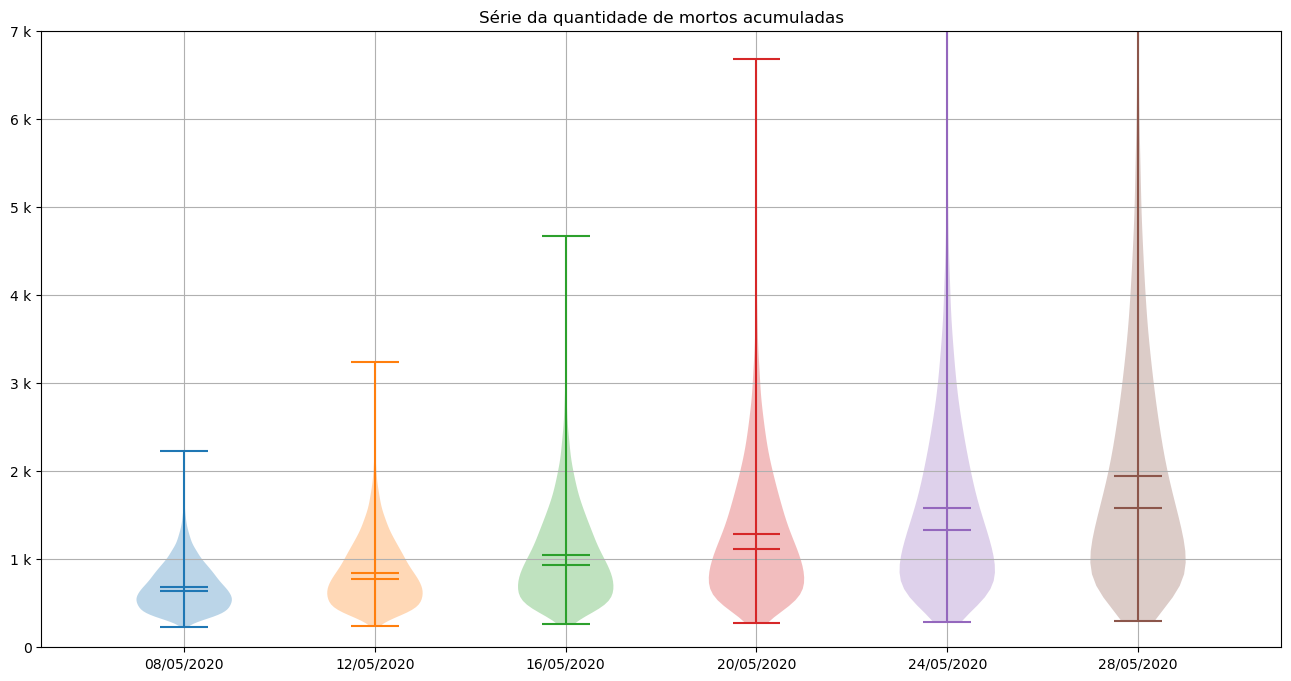

In [46]:
ts = 40:4:60
xs, ws = build_series(series, idxs, ts);
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("Série da quantidade de mortos acumuladas")
ax.set_ylim(0,7000)
ax.grid()
graph_py.graph_series(xs,ws,ts,ax)

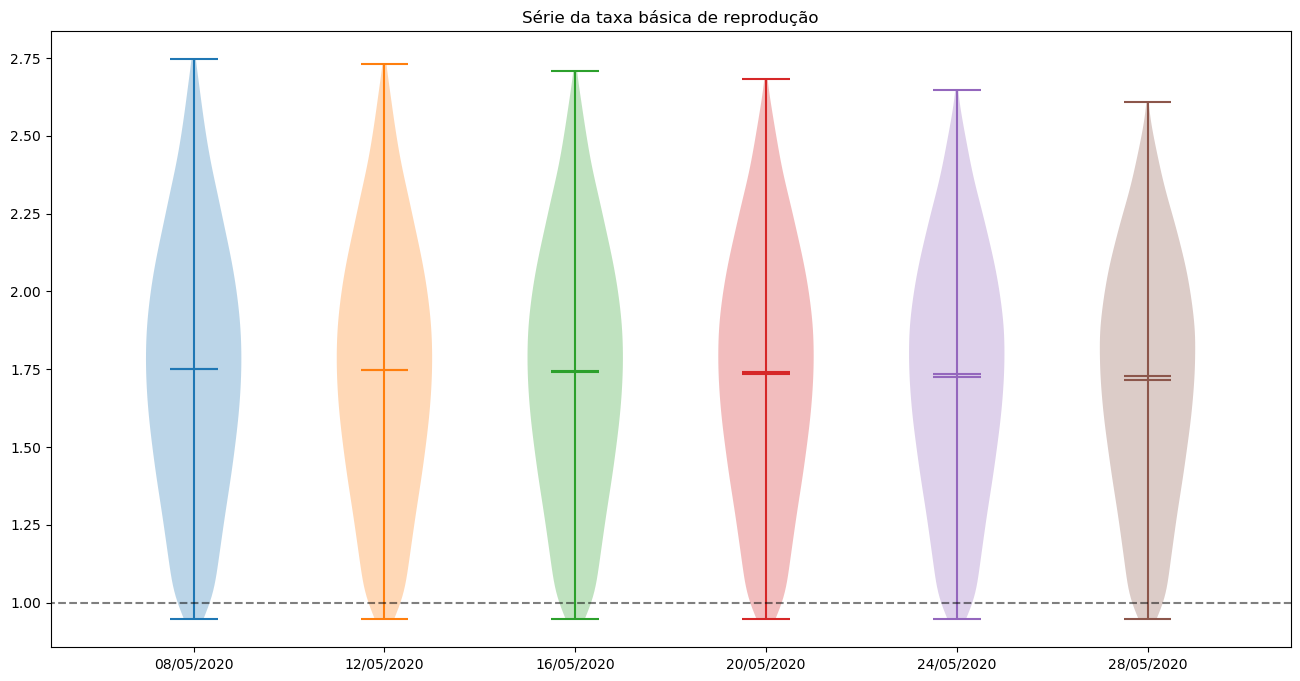

In [47]:
ts = 40:4:60
xs = [[Rt(series[j][1]["res"],p_opt)[t] for j in idxs] for t in ts]
ws = [[series[j][2] for j in idxs] for t in ts];
graph_py.graph_rt(xs,ws,ts)

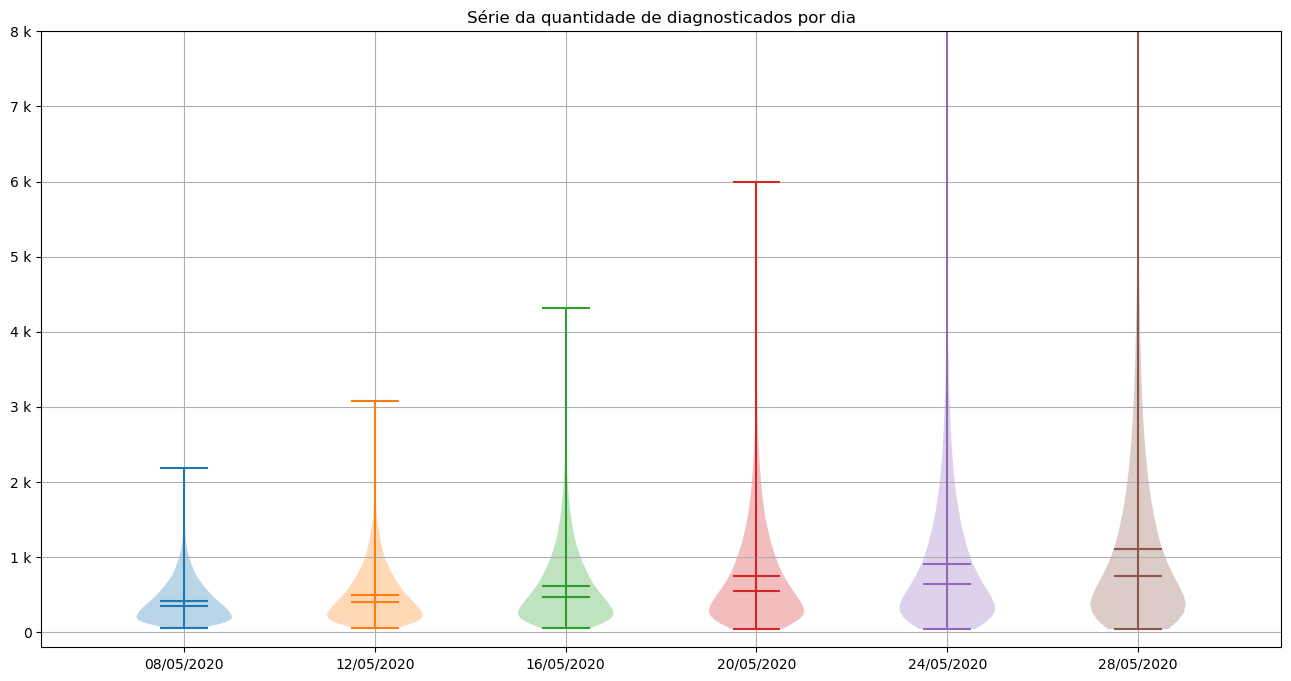

In [48]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:4:60
xs,ws = build_series_daily(series, idxs, ts, index = 9)
ax.set_title("Série da quantidade de diagnosticados por dia")
ax.set_ylim(-200,8000)
ax.grid()
graph_py.graph_series(xs,ws,ts,ax)

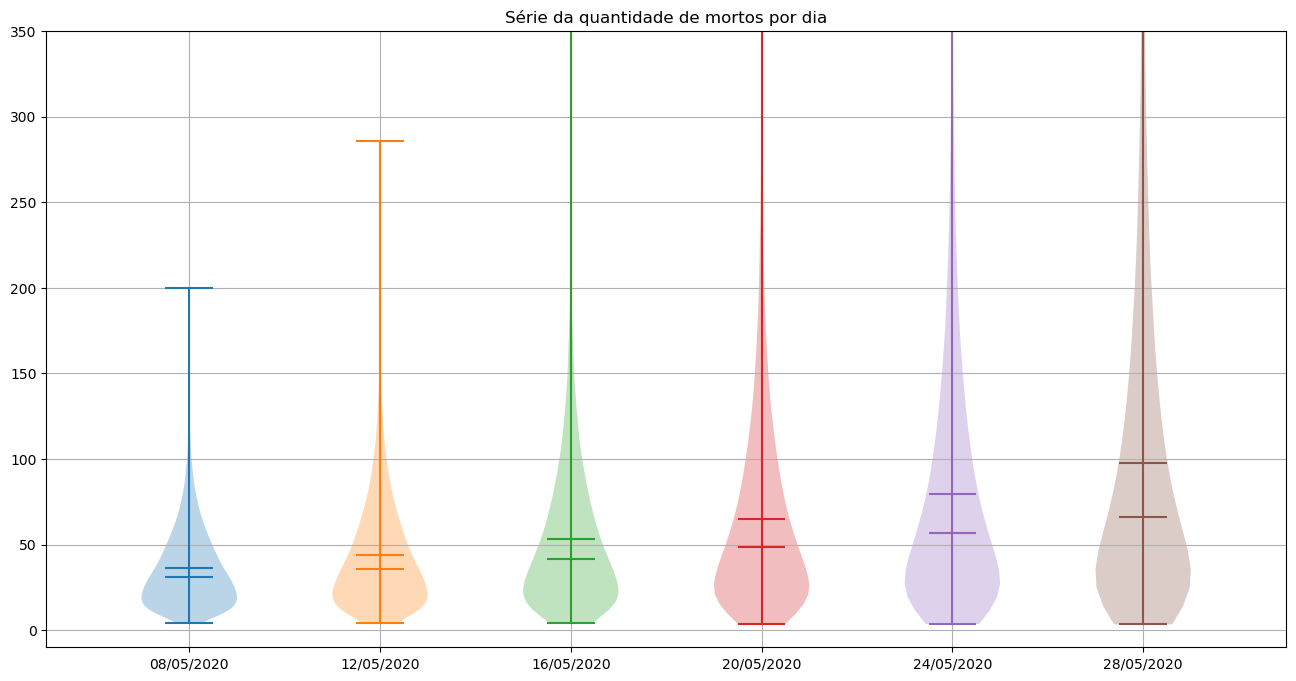

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:4:60
xs,ws = build_series_daily(series, idxs, ts)
ax.set_title("Série da quantidade de mortos por dia")
ax.set_ylim(-10,350)
ax.grid()
graph_py.graph_series(xs,ws,ts,ax)

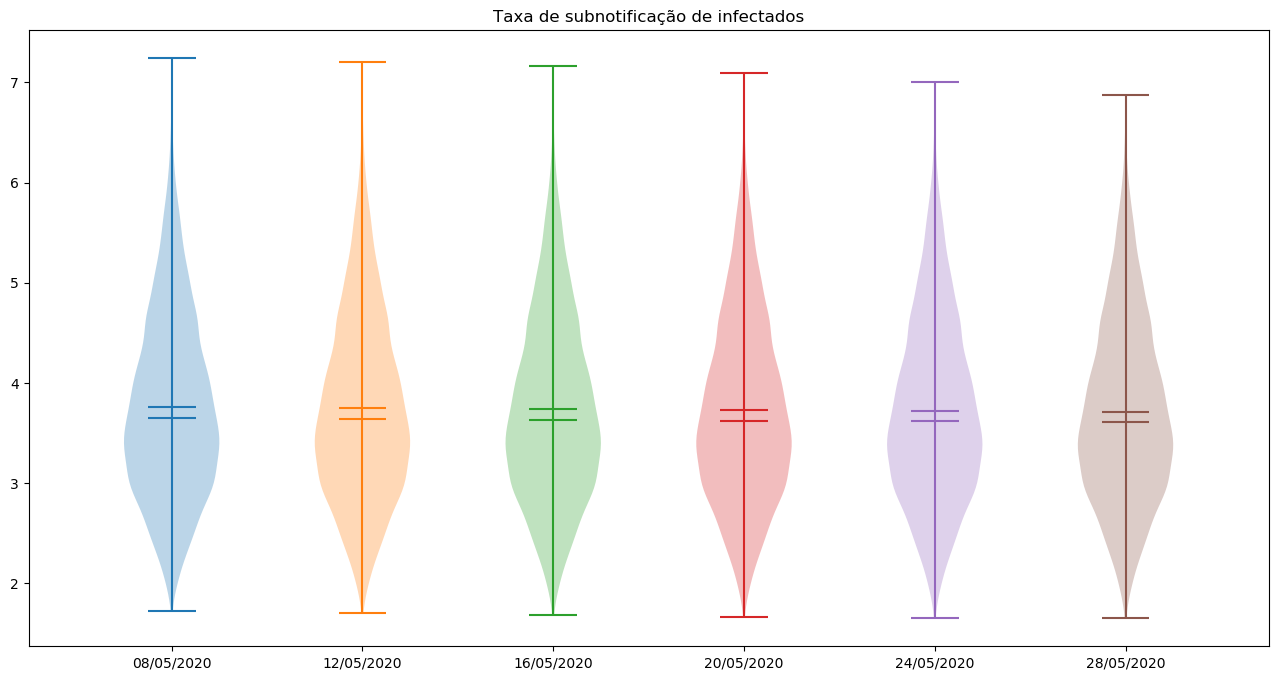

In [50]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:4:60
xs,ws = build_series_subnot_infec(series, idxs, ts)
ax.set_title("Taxa de subnotificação de infectados")
graph_py.graph_series(xs,ws,ts,ax)

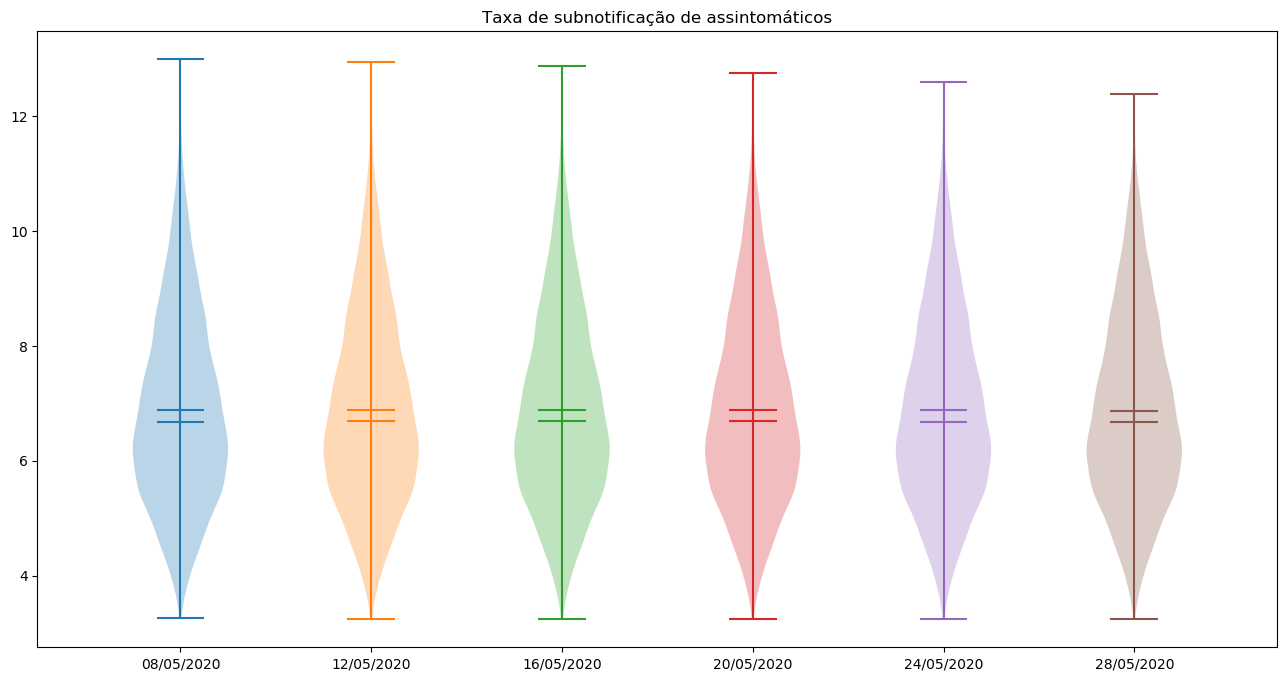

In [51]:
fig, ax = plt.subplots(figsize=(16,8))
ts = 40:4:60
xs,ws = build_series_subnot_assint(series, idxs, ts)
ax.set_title("Taxa de subnotificação de assintomáticos")
graph_py.graph_series(xs,ws,ts,ax)